# Added Moving averages

In [ ]:
# ────────────────────────────────────────────────────────────────────────────
# 0) Installs + imports
!pip install tensorflow scikit-learn openpyxl --quiet

# ─── Reproducibility ─────────────────────────────────────────────────────────
import os, random
import numpy as np
import tensorflow as tf

SEED = 42
os.environ['PYTHONHASHSEED']      = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'       # force TF deterministic ops
random.seed(SEED)                             # Python built-in RNG
np.random.seed(SEED)                          # NumPy RNG
tf.random.set_seed(SEED)                      # TensorFlow RNG

# ────────────────────────────────────────────────────────────────────────────
import json
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.metrics       import (
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    accuracy_score
)

from tensorflow.keras.models       import Sequential
from tensorflow.keras.layers       import LSTM, Dense, Dropout
from tensorflow.keras.callbacks    import EarlyStopping
from tensorflow.keras.regularizers import l2
# ────────────────────────────────────────────────────────────────────────────



# ────────────────────────────────────────────────────────────────────────────
# 1) Define your target and “expected” feature‐lists (before seeing the files)
TARGET = "return_t+1"

ORIG_ALL_FEATS = [
    "IWSS_Equal","IWSS_Ratio","IWSS_Impurity","IWSS_perm","IWSS_SHAP",
    "Sentiment_score","return_t","Close","High","Low","Open","Volume","VIX"
]
ORIG_PRICE_FEATS = ["return_t","Close","High","Low","Open","Volume","VIX"]
ORIG_SENT_FEATS  = [
    "IWSS_Equal","IWSS_Ratio","IWSS_Impurity","IWSS_perm","IWSS_SHAP",
    "Sentiment_score"
]
# ────────────────────────────────────────────────────────────────────────────


# 2) Load raw data (no dropna)
def load_raw(path):
    df = pd.read_excel(path, parse_dates=["trading_day", "Date"])
    return df.sort_values("trading_day").reset_index(drop=True)

train_df = load_raw("/content/drive/MyDrive/Masters Thesis/Colab notebook/combined_training_data_.xlsx")
val_df   = load_raw("/content/drive/MyDrive/Masters Thesis/Colab notebook/combined_validation_data.xlsx")
test_df  = load_raw("/content/drive/MyDrive/Masters Thesis/Colab notebook/combined_test_data.xlsx")


# 3) Check which expected features actually exist in train_df
present_cols = set(train_df.columns)
missing_feats = [f for f in ORIG_ALL_FEATS if f not in present_cols]
if missing_feats:
    print(f"⚠️ Warning: These expected features are missing from the raw data and will be dropped:\n  {missing_feats}")

# 4) Filter down your feature‐lists to what’s actually present
ALL_FEATS   = [f for f in ORIG_ALL_FEATS   if f in present_cols]
PRICE_FEATS = [f for f in ORIG_PRICE_FEATS if f in present_cols]
SENT_FEATS  = [f for f in ORIG_SENT_FEATS  if f in present_cols]


# 5) Engineer new features
def add_engineered_features(df):
    df = df.copy()
    df["Close_diff"]  = df["Close"].diff()
    df["Volume_diff"] = df["Volume"].diff()
    df["VIX_diff"]    = df["VIX"].diff()
    df["Close_ma5"]   = df["Close"].rolling(5).mean()
    df["Volume_ma5"]  = df["Volume"].rolling(5).mean()
    df["VIX_ma5"]     = df["VIX"].rolling(5).mean()
    return df

train_df = add_engineered_features(train_df)
val_df   = add_engineered_features(val_df)
test_df  = add_engineered_features(test_df)

# 6) Append those engineered features to your lists
new_feats = ["Close_diff", "Volume_diff", "VIX_diff", "Close_ma5", "Volume_ma5", "VIX_ma5"]
ALL_FEATS   += new_feats
PRICE_FEATS += new_feats

# 7) Now drop rows missing *any* of the final features or the target
for df in (train_df, val_df, test_df):
    df.dropna(subset=ALL_FEATS + [TARGET], inplace=True)
    df.reset_index(drop=True, inplace=True)


# 8) Prepare regression target and binary up/down
y_train_reg = train_df[TARGET].values
y_val_reg   = val_df  [TARGET].values
y_test_reg  = test_df [TARGET].values

train_df["up"] = (train_df[TARGET] > 0).astype(int)
val_df  ["up"] = (val_df  [TARGET] > 0).astype(int)
test_df ["up"] = (test_df [TARGET] > 0).astype(int)

y_train_clf = train_df["up"].values
y_val_clf   = val_df  ["up"].values
y_test_clf  = test_df ["up"].values


# 9) Scale each feature‐set on the training split
scalers = {}
for name, feats in [("full", ALL_FEATS), ("price", PRICE_FEATS), ("sent", SENT_FEATS)]:
    sc = StandardScaler().fit(train_df[feats])
    scalers[name] = sc
    train_df[f"X_{name}"] = list(sc.transform(train_df[feats]))
    val_df  [f"X_{name}"] = list(sc.transform(val_df  [feats]))
    test_df [f"X_{name}"] = list(sc.transform(test_df [feats]))


# 10) Sequence builder
def make_sequences(X_list, y, lookback=10):
    Xs, ys = [], []
    for i in range(lookback, len(X_list)):
        Xs.append(np.stack(X_list[i-lookback:i], axis=0))
        ys.append(y[i])
    return np.array(Xs), np.array(ys)


# 11) Model factory functions
def build_regressor(n_feat, lr=1e-4, reg=1e-5):
    m = Sequential([
        tf.keras.Input(shape=(None, n_feat)),
        LSTM(64, return_sequences=True, kernel_regularizer=l2(reg)),
        Dropout(0.1),
        LSTM(32, kernel_regularizer=l2(reg)),
        Dropout(0.1),
        Dense(1, activation="linear", kernel_regularizer=l2(reg))
    ])
    m.compile(optimizer=tf.keras.optimizers.Adam(lr),
              loss="mse", metrics=["mae"])
    return m

def build_classifier(n_feat, lr=1e-4, reg=1e-5):
    m = Sequential([
        tf.keras.Input(shape=(None, n_feat)),
        LSTM(32, kernel_regularizer=l2(reg)),
        Dropout(0.1),
        Dense(1, activation="sigmoid", kernel_regularizer=l2(reg))
    ])
    m.compile(optimizer=tf.keras.optimizers.Adam(lr),
              loss="binary_crossentropy",
              metrics=["accuracy"])
    return m

# ────────────────────────────────────────────────────────────────────────────
# Assumes you’ve already done steps 0–11 (data loading, feature engineering,
# scalers, make_sequences, build_regressor, build_classifier, etc.)
# ────────────────────────────────────────────────────────────────────────────

# 1) Initialize tracker for best validation directional accuracy
best = {
    "dir_acc":  -np.inf,   # best directional accuracy so far
    "feat_set": None,      # which feature set
    "lookback": None,      # which lookback
    "r2":       None,      # validation R² at that best
    "rmse":     None       # validation RMSE at that best
}

# 2) Updated run_experiment returns its three val‐metrics
def run_experiment(feat_set, lookback):
    # prepare sequences
    Xtr_list = train_df[f"X_{feat_set}"]
    Xvl_list = val_df  [f"X_{feat_set}"]
    ytr, yvl = y_train_reg, y_val_reg

    Xtr, ytr = make_sequences(Xtr_list, ytr, lookback)
    Xvl, yvl = make_sequences(Xvl_list, yvl, lookback)

    # build & train
    model = build_regressor(Xtr.shape[2]) # build_regressor is now defined in the scope
    es    = EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True)
    model.fit(
        Xtr, ytr,
        validation_data=(Xvl, yvl),
        epochs=100, batch_size=32,
        callbacks=[es],
        verbose=0
    )

    # predict on validation only
    pred_v = model.predict(Xvl).flatten()

    # compute metrics
    r2_v      = r2_score(yvl, pred_v)
    rmse_v    = np.sqrt(mean_squared_error(yvl, pred_v))
    dir_acc_v = accuracy_score(yvl > 0, pred_v > 0)

    # print summary
    print(
        f"[REG] {feat_set:5s} LB={lookback:2d} → "
        f"Val R²={r2_v:+.3f}, Val RMSE={rmse_v:.4f}, "
        f"Val Dir Acc={dir_acc_v:.3f}"
    )

    return {"r2": r2_v, "rmse": rmse_v, "dir_acc": dir_acc_v}


# 3) Run the grid and update best
LOOKBACKS = [15, 30, 45, 60]
FEATURE_SETS = ["full", "price", "sent"]

for lb in LOOKBACKS:
    for fs in FEATURE_SETS:
        metrics = run_experiment(fs, lb)
        if metrics["dir_acc"] > best["dir_acc"]:
            best.update({
                "dir_acc":  metrics["dir_acc"],
                "feat_set": fs,
                "lookback": lb,
                "r2":       metrics["r2"],
                "rmse":     metrics["rmse"]
            })

# 4) Report and save best
print("\n>>> BEST VALIDATION RESULT:")
print(
    f"  feat_set = '{best['feat_set']}', lookback = {best['lookback']}\n"
    f"  → Val R² = {best['r2']:+.3f}\n"
    f"  → Val RMSE = {best['rmse']:.4f}\n"
    f"  → Val Dir Acc = {best['dir_acc']:.3f}"
)

with open("best_val_metrics.json", "w") as f:
    json.dump(best, f, indent=2)

print("Saved best validation metrics to best_val_metrics.json")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step  
[REG] full  LB=15 → Val R²=-4.329, Val RMSE=0.0159, Val Dir Acc=0.477
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step  
[REG] price LB=15 → Val R²=-14.337, Val RMSE=0.0269, Val Dir Acc=0.531
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step  
[REG] sent  LB=15 → Val R²=-0.295, Val RMSE=0.0078, Val Dir Acc=0.453
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
[REG] full  LB=30 → Val R²=-45.730, Val RMSE=0.0484, Val Dir Acc=0.513
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step
[REG] price LB=30 → Val R²=-112.782, Val RMSE=0.0755, Val Dir Acc=0.531
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
[REG] sent  LB=30 → Val R²=-0.051, Val RMSE=0.0073, Val Dir Acc=0.602
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
[REG] full  LB=45 → Val R²=-39.776, Val RMSE=0.0454, Val Dir Acc=0.459
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
[REG] price LB=45 → Val R²=-12.994, Val RMSE=0.0266, Val Dir Acc=0.429
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
[REG] sent  LB=45 → Val R²=-0.459, Val RMSE=0.0086, Val Dir Acc=0.480
3/3 ━━━━━━━━━━━━━━━

Epoch 1/300
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - loss: 0.0026 - mae: 0.0316 - val_loss: 0.0012 - val_mae: 0.0126
Epoch 2/300
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0020 - mae: 0.0237 - val_loss: 0.0012 - val_mae: 0.0140
Epoch 3/300
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0017 - mae: 0.0196 - val_loss: 0.0011 - val_mae: 0.0088
Epoch 4/300
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0018 - mae: 0.0205 - val_loss: 0.0012 - val_mae: 0.0131
Epoch 5/300
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0017 - mae: 0.0189 - val_loss: 0.0011 - val_mae: 0.0098
Epoch 6/300
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0015 - mae: 0.0185 - val_loss: 0.0011 - val_mae: 0.0095
Epoch 7/300
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0016 - mae: 0.0175 - val_loss: 0.0011 - val_mae: 0.0088
Epoch 8/300
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0015 - mae: 0.0181 - val_loss: 0.0011 - val_mae: 0.0105
Epoch 9/300
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - lo

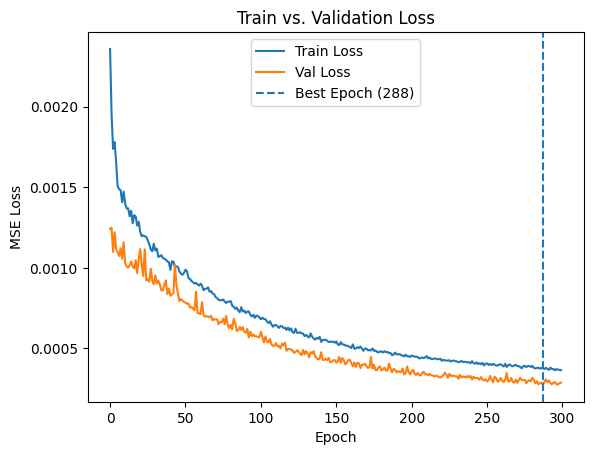

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# (Assuming all seeds are already set above)

# 1) Build sequences for your chosen config
feat_set, lookback = 'sent', 30
Xtr_list = train_df[f"X_{feat_set}"]
Xvl_list = val_df  [f"X_{feat_set}"]
ytr, yvl = y_train_reg, y_val_reg

Xtr, ytr_seq = make_sequences(Xtr_list, ytr, lookback)
Xvl, yvl_seq = make_sequences(Xvl_list, yvl, lookback)

# 2) Compile & fit, capturing history
model = build_regressor(Xtr.shape[2])
es    = EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True)
history = model.fit(
    Xtr, ytr_seq,
    validation_data=(Xvl, yvl_seq),
    epochs=300, batch_size=32,
    callbacks=[es],
    verbose=1,
    shuffle=True           # shuffling is deterministic thanks to the seed
)

# 3) Identify best epoch
best_epoch = int(np.argmin(history.history['val_loss']) + 1)
print(f"Best validation loss at epoch {best_epoch}")

# 4) Plot (will be identical every run)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.axvline(best_epoch-1, linestyle='--', label=f'Best Epoch ({best_epoch})')
plt.title('Train vs. Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

# Simple model

In [3]:
!pip install tensorflow pandas numpy scikit-learn matplotlib openpyxl --quiet

Epoch 1/200
15/15 - 5s - 344ms/step - directional_accuracy: 0.4953 - loss: 0.0396 - r2: -6.6600e+02 - val_directional_accuracy: 0.5591 - val_loss: 0.0344 - val_r2: -1.2211e+03
Epoch 2/200
15/15 - 1s - 38ms/step - directional_accuracy: 0.5067 - loss: 0.0191 - r2: -1.6842e+02 - val_directional_accuracy: 0.5810 - val_loss: 0.0260 - val_r2: -6.9561e+02
Epoch 3/200
15/15 - 1s - 36ms/step - directional_accuracy: 0.4886 - loss: 0.0152 - r2: -1.1793e+02 - val_directional_accuracy: 0.5696 - val_loss: 0.0226 - val_r2: -5.4630e+02
Epoch 4/200
15/15 - 0s - 23ms/step - directional_accuracy: 0.4991 - loss: 0.0130 - r2: -7.1226e+01 - val_directional_accuracy: 0.4647 - val_loss: 0.0138 - val_r2: -2.0449e+02
Epoch 5/200
15/15 - 0s - 13ms/step - directional_accuracy: 0.5103 - loss: 0.0127 - r2: -6.8171e+01 - val_directional_accuracy: 0.5406 - val_loss: 0.0137 - val_r2: -2.1756e+02
Epoch 6/200
15/15 - 0s - 12ms/step - directional_accuracy: 0.4952 - loss: 0.0117 - r2: -5.5634e+01 - val_directional_accurac

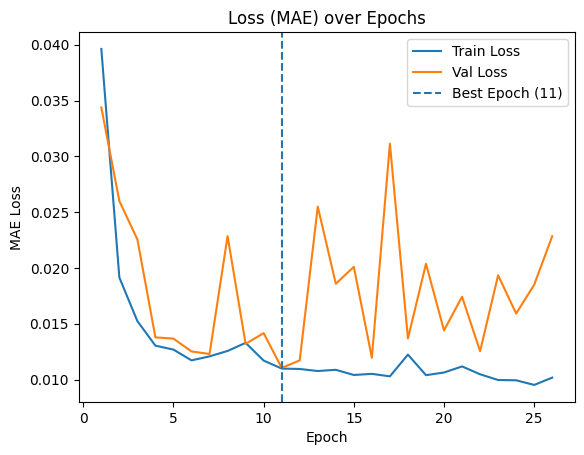

1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Best Epoch: 11
Val MSE:    0.000222
Val MAE:    0.011047
Val RMSE:   0.014905
Val R²:     -3.556419
Dir Acc.:   0.5510


In [13]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# --- custom metrics for Keras ---
@tf.keras.utils.register_keras_serializable()
def r2(y_true, y_pred):
    ss_res = tf.reduce_sum(tf.square(y_true - y_pred))
    ss_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    return 1 - ss_res / (ss_tot + tf.keras.backend.epsilon())

@tf.keras.utils.register_keras_serializable()
def directional_accuracy(y_true, y_pred):
    return tf.reduce_mean(
        tf.cast(tf.equal(tf.sign(y_true), tf.sign(y_pred)), tf.float32)
    )

# --- data loading & preprocessing ---
def load_data(path):
    df = pd.read_excel(path)
    df['Date'] = pd.to_datetime(df['Date'])
    return df.sort_values('Date').reset_index(drop=True)

# drop NaNs, scale, reshape
def prepare_data(df, features, target, scaler=None):
    df_clean = df.dropna(subset=features + [target])
    X = df_clean[features].values
    y = df_clean[target].values
    if scaler is None:
        scaler = StandardScaler().fit(X)
    X = scaler.transform(X)
    X = X.reshape((X.shape[0], 1, X.shape[1]))
    return X, y, scaler

# --- model builder ---
def build_model(input_shape):
    model = Sequential([
        tf.keras.Input(shape=input_shape),
        LSTM(50),
        Dense(1)
    ])
    model.compile(
        optimizer='adam',
        loss='mae',
        metrics=[r2, directional_accuracy]
    )
    return model

# --- plotting ---
def plot_history(history):
    best_epoch = np.argmin(history.history['val_loss'])
    epochs = np.arange(1, len(history.history['loss']) + 1)

    plt.figure()
    plt.plot(epochs, history.history['loss'], label='Train Loss')
    plt.plot(epochs, history.history['val_loss'], label='Val Loss')
    plt.axvline(best_epoch+1, linestyle='--', label=f'Best Epoch ({best_epoch+1})')
    plt.title('Loss (MAE) over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('MAE Loss')
    plt.legend()
    plt.show()

    return best_epoch

# --- execution ---
def main():
    # file paths
    train_path = '/content/drive/MyDrive/Masters Thesis/Colab notebook/combined_training_data_.xlsx'
    val_path   = '/content/drive/MyDrive/Masters Thesis/Colab notebook/combined_validation_data.xlsx'

    # load data
    train_df = load_data(train_path)
    val_df   = load_data(val_path)

    # specify target and features
    target = 'return_t+1'
    numeric_cols = train_df.select_dtypes(include=[np.number]).columns.tolist()
    features = [c for c in numeric_cols if c != target]

    # prepare datasets
    X_train, y_train, scaler = prepare_data(train_df, features, target)
    X_val,   y_val,   _      = prepare_data(val_df,   features, target, scaler)

    # build and train model
    model = build_model((X_train.shape[1], X_train.shape[2]))
    os.makedirs('models', exist_ok=True)
    ckpt_path = 'models/best_model.keras'
    callbacks = [
        ModelCheckpoint(ckpt_path, monitor='val_loss', save_best_only=True),
        EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    ]
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=200,
        batch_size=32,
        callbacks=callbacks,
        verbose=2
    )

    # plot training history and find best epoch
    best_epoch = plot_history(history)

    # load best model weights
    if os.path.exists(ckpt_path):
        model = load_model(
            ckpt_path,
            custom_objects={'r2': r2, 'directional_accuracy': directional_accuracy}
        )

    # predict on validation set
    y_pred = model.predict(X_val).flatten()

    # compute evaluation metrics
    mse    = mean_squared_error(y_val, y_pred)
    rmse   = np.sqrt(mse)
    mae    = mean_absolute_error(y_val, y_pred)
    r2_val = r2_score(y_val, y_pred)
    dir_acc= np.mean(np.sign(y_pred) == np.sign(y_val))

    # display results
    print(f"Best Epoch: {best_epoch+1}")
    print(f"Val MSE:    {mse:.6f}")
    print(f"Val MAE:    {mae:.6f}")
    print(f"Val RMSE:   {rmse:.6f}")
    print(f"Val R²:     {r2_val:.6f}")
    print(f"Dir Acc.:   {dir_acc:.4f}")

if __name__ == '__main__':
    main()


# SPYVIX w. MA

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step  
[REG] full LB=15 → R²=-0.915, RMSE=0.0095, DirAcc=0.430
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step 
[REG] price LB=15 → R²=-4.308, RMSE=0.0158, DirAcc=0.508
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step  
[REG] sent LB=15 → R²=-0.089, RMSE=0.0071, DirAcc=0.492
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
[REG] full LB=30 → R²=-2.665, RMSE=0.0135, DirAcc=0.575
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
[REG] price LB=30 → R²=-1.695, RMSE=0.0116, DirAcc=0.531
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
[REG] sent LB=30 → R²=-0.060, RMSE=0.0073, DirAcc=0.549
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
[REG] full LB=45 → R²=-0.347, RMSE=0.0082, DirAcc=0.551
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
[REG] price LB=45 → R²=-0.281, RMSE=0.0080, DirAcc=0.459
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
[REG] sent LB=45 → R²=-0.441, RMSE=0.0085, DirAcc=0.429
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
[REG] full LB=60 → R²=-18.250, RMSE=0.0307, DirAcc=0.566
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
[REG] price LB=

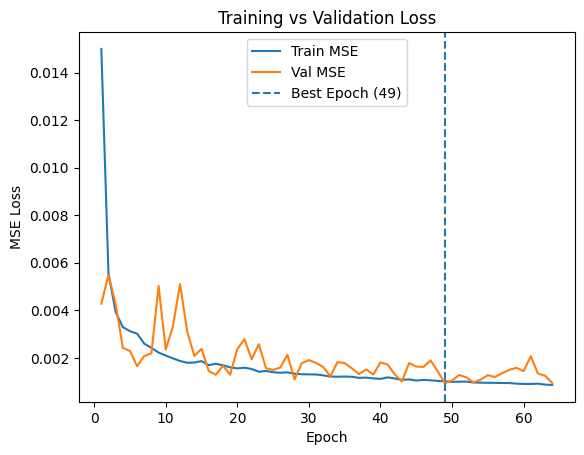

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Validation MAE:  0.011280
Validation MSE:  0.000182
Validation RMSE: 0.013484
Validation R²:   -2.665361
Validation DirAcc: 0.575


In [15]:
# ────────────────────────────────────────────────────────────────────────────
# 0) Installs + imports
!pip install tensorflow scikit-learn openpyxl --quiet

# ─── Reproducibility ─────────────────────────────────────────────────────────
import os, random
import numpy as np
import tensorflow as tf

SEED = 42
os.environ['PYTHONHASHSEED']      = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# ────────────────────────────────────────────────────────────────────────────
import pandas as pd
from sklearn.preprocessing    import StandardScaler
from sklearn.metrics          import (
    mean_squared_error, mean_absolute_error, r2_score, accuracy_score
)
from tensorflow.keras.models       import Sequential
from tensorflow.keras.layers       import LSTM, Dense, Dropout
from tensorflow.keras.callbacks    import EarlyStopping
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt

# 1) Define target & feature lists
TARGET = "return_t+1"
ORIG_ALL_FEATS = [
    "IWSS_Equal","IWSS_Ratio","IWSS_Impurity","IWSS_perm","IWSS_SHAP",
    "Sentiment_score","return_t","Close","High","Low","Open","Volume","VIX"
]
ORIG_PRICE_FEATS = ["return_t","Close","High","Low","Open","Volume","VIX"]
ORIG_SENT_FEATS  = [
    "IWSS_Equal","IWSS_Ratio","IWSS_Impurity","IWSS_perm","IWSS_SHAP",
    "Sentiment_score"
]

# 2) Load raw data
def load_raw(path):
    df = pd.read_excel(path, parse_dates=["trading_day","Date"])
    return df.sort_values("trading_day").reset_index(drop=True)

train_df = load_raw("/content/drive/MyDrive/Masters Thesis/Colab notebook/combined_training_data_add_spyvix.xlsx")
val_df   = load_raw("/content/drive/MyDrive/Masters Thesis/Colab notebook/combined_validation_data_add_spyvix.xlsx")

# 3) Filter feature lists
present = set(train_df.columns)
ALL_FEATS   = [f for f in ORIG_ALL_FEATS   if f in present]
PRICE_FEATS = [f for f in ORIG_PRICE_FEATS if f in present]
SENT_FEATS  = [f for f in ORIG_SENT_FEATS  if f in present]

# 4) Engineer features
def add_feats(df):
    df = df.copy()
    df["Close_diff"]  = df["Close"].diff()
    df["Volume_diff"] = df["Volume"].diff()
    df["VIX_diff"]    = df["VIX"].diff()
    for col in ["Close","Volume","VIX"]:
        df[f"{col}_ma5"] = df[col].rolling(5).mean()
    return df

train_df = add_feats(train_df)
val_df   = add_feats(val_df)
new_feats = ["Close_diff","Volume_diff","VIX_diff","Close_ma5","Volume_ma5","VIX_ma5"]
ALL_FEATS += new_feats
PRICE_FEATS += new_feats

# 5) Drop NaNs
for df in (train_df, val_df):
    df.dropna(subset=ALL_FEATS + [TARGET], inplace=True)
    df.reset_index(drop=True, inplace=True)

# 6) Prepare targets
y_train = train_df[TARGET].values
y_val   = val_df[TARGET].values
train_df['up'] = (y_train > 0).astype(int)
val_df['up']   = (y_val > 0).astype(int)

# 7) Scale feature sets
for name, feats in [("full", ALL_FEATS), ("price", PRICE_FEATS), ("sent", SENT_FEATS)]:
    sc = StandardScaler().fit(train_df[feats])
    train_df[f"X_{name}"] = list(sc.transform(train_df[feats]))
    val_df  [f"X_{name}"] = list(sc.transform(val_df[feats]))

# 8) Sequence builder
def make_seq(X_list, y, lb):
    Xs, ys = [], []
    for i in range(lb, len(X_list)):
        Xs.append(np.stack(X_list[i-lb:i], axis=0))
        ys.append(y[i])
    return np.array(Xs), np.array(ys)

# 9) Model factory
def build_reg(n_feat):
    m = Sequential([
        tf.keras.Input(shape=(None, n_feat)),
        LSTM(64, return_sequences=True, kernel_regularizer=l2(1e-5)),
        Dropout(0.1),
        LSTM(32, kernel_regularizer=l2(1e-5)),
        Dropout(0.1),
        Dense(1)
    ])
    m.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return m

# 10) Grid search
best = {'dir_acc': -np.inf, 'feat': None, 'lb': None, 'r2': None, 'rmse': None}
best_model = None
best_hist = None
LOOK = [15, 30, 45, 60]
SETS = ['full', 'price', 'sent']

for lb in LOOK:
    for fs in SETS:
        # convert series to list to avoid dtype issues
        Xtr_list = train_df[f"X_{fs}"].tolist()
        Xvl_list = val_df  [f"X_{fs}"].tolist()
        Xtr, ytr = make_seq(Xtr_list, y_train, lb)
        Xvl, yvl = make_seq(Xvl_list, y_val,   lb)

        model = build_reg(Xtr.shape[2])
        es = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
        hist = model.fit(
            Xtr, ytr,
            validation_data=(Xvl, yvl),
            epochs=100, batch_size=32,
            callbacks=[es], verbose=0
        )

        pred = model.predict(Xvl).flatten()
        r2v = r2_score(yvl, pred)
        rmsev = np.sqrt(mean_squared_error(yvl, pred))
        dirv = accuracy_score(yvl > 0, pred > 0)

        print(f"[REG] {fs} LB={lb} → R²={r2v:+.3f}, RMSE={rmsev:.4f}, DirAcc={dirv:.3f}")

        if dirv > best['dir_acc']:
            best.update({'dir_acc': dirv, 'feat': fs, 'lb': lb, 'r2': r2v, 'rmse': rmsev})
            best_model = model
            best_hist = hist

# 11) Final report & plot
print("\n>>> BEST SETTING:")
print(f"Feature={best['feat']}, Lookback={best['lb']} → "
      f"R²={best['r2']:+.3f}, RMSE={best['rmse']:.4f}, DirAcc={best['dir_acc']:.3f}")

# plot history with best epoch marker
h = best_hist
best_epoch = np.argmin(h.history['val_loss']) + 1
epochs = range(1, len(h.history['loss']) + 1)
plt.figure()
plt.plot(epochs, h.history['loss'], label='Train MSE')
plt.plot(epochs, h.history['val_loss'], label='Val MSE')
plt.axvline(best_epoch, linestyle='--', label=f'Best Epoch ({best_epoch})')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

# 12) Final evaluation on validation
Xvl_best, yvl_best = make_seq(val_df[f"X_{best['feat']}"].tolist(), y_val, best['lb'])
pred_best = best_model.predict(Xvl_best).flatten()
mae_v  = mean_absolute_error(yvl_best, pred_best)
mse_v  = mean_squared_error(yvl_best, pred_best)
rmse_v = np.sqrt(mse_v)
r2_v   = r2_score(yvl_best, pred_best)
dir_v  = accuracy_score(yvl_best > 0, pred_best > 0)

print(f"Validation MAE:  {mae_v:.6f}")
print(f"Validation MSE:  {mse_v:.6f}")
print(f"Validation RMSE: {rmse_v:.6f}")
print(f"Validation R²:   {r2_v:.6f}")
print(f"Validation DirAcc: {dir_v:.3f}")


# SPYVIX simple model

In [16]:
!pip install tensorflow pandas numpy scikit-learn matplotlib openpyxl --quiet

Epoch 1/200
15/15 - 5s - 341ms/step - directional_accuracy: 0.5053 - loss: 0.0390 - r2: -7.2260e+02 - val_directional_accuracy: 0.5888 - val_loss: 0.0901 - val_r2: -8.3993e+03
Epoch 2/200
15/15 - 0s - 19ms/step - directional_accuracy: 0.4885 - loss: 0.0192 - r2: -1.3731e+02 - val_directional_accuracy: 0.6099 - val_loss: 0.0499 - val_r2: -2.4532e+03
Epoch 3/200
15/15 - 1s - 50ms/step - directional_accuracy: 0.4924 - loss: 0.0171 - r2: -1.2099e+02 - val_directional_accuracy: 0.5627 - val_loss: 0.0206 - val_r2: -5.2222e+02
Epoch 4/200
15/15 - 1s - 51ms/step - directional_accuracy: 0.4664 - loss: 0.0141 - r2: -7.0702e+01 - val_directional_accuracy: 0.5748 - val_loss: 0.0185 - val_r2: -4.3335e+02
Epoch 5/200
15/15 - 1s - 36ms/step - directional_accuracy: 0.4814 - loss: 0.0129 - r2: -6.3581e+01 - val_directional_accuracy: 0.5410 - val_loss: 0.0164 - val_r2: -3.3568e+02
Epoch 6/200
15/15 - 1s - 34ms/step - directional_accuracy: 0.5047 - loss: 0.0123 - r2: -6.5730e+01 - val_directional_accurac

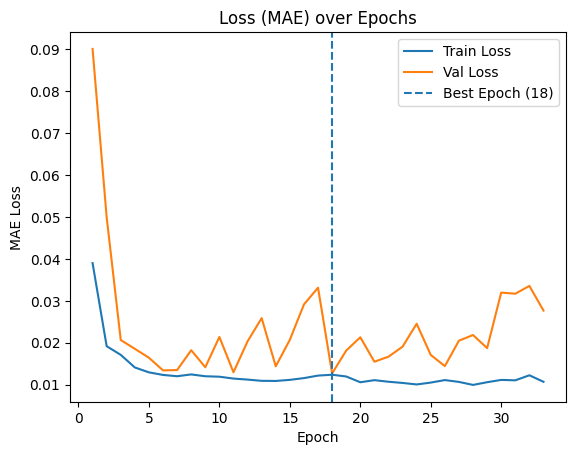

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 171ms/step
Best Epoch: 18
Val MSE:    0.000317
Val MAE:    0.012666
Val RMSE:   0.017798
Val R²:     -5.520367
Dir Acc.:   0.5306


In [17]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# --- custom metrics for Keras ---
@tf.keras.utils.register_keras_serializable()
def r2(y_true, y_pred):
    ss_res = tf.reduce_sum(tf.square(y_true - y_pred))
    ss_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    return 1 - ss_res / (ss_tot + tf.keras.backend.epsilon())

@tf.keras.utils.register_keras_serializable()
def directional_accuracy(y_true, y_pred):
    return tf.reduce_mean(
        tf.cast(tf.equal(tf.sign(y_true), tf.sign(y_pred)), tf.float32)
    )

# --- data loading & preprocessing ---
def load_data(path):
    df = pd.read_excel(path)
    df['Date'] = pd.to_datetime(df['Date'])
    return df.sort_values('Date').reset_index(drop=True)

# drop NaNs, scale, reshape
def prepare_data(df, features, target, scaler=None):
    df_clean = df.dropna(subset=features + [target])
    X = df_clean[features].values
    y = df_clean[target].values
    if scaler is None:
        scaler = StandardScaler().fit(X)
    X = scaler.transform(X)
    X = X.reshape((X.shape[0], 1, X.shape[1]))
    return X, y, scaler

# --- model builder ---
def build_model(input_shape):
    model = Sequential([
        tf.keras.Input(shape=input_shape),
        LSTM(50),
        Dense(1)
    ])
    model.compile(
        optimizer='adam',
        loss='mae',
        metrics=[r2, directional_accuracy]
    )
    return model

# --- plotting ---
def plot_history(history):
    best_epoch = np.argmin(history.history['val_loss'])
    epochs = np.arange(1, len(history.history['loss']) + 1)

    plt.figure()
    plt.plot(epochs, history.history['loss'], label='Train Loss')
    plt.plot(epochs, history.history['val_loss'], label='Val Loss')
    plt.axvline(best_epoch+1, linestyle='--', label=f'Best Epoch ({best_epoch+1})')
    plt.title('Loss (MAE) over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('MAE Loss')
    plt.legend()
    plt.show()

    return best_epoch

# --- execution ---
def main():
    # file paths
    train_path = '/content/drive/MyDrive/Masters Thesis/Colab notebook/combined_training_data_add_spyvix.xlsx'
    val_path   = '/content/drive/MyDrive/Masters Thesis/Colab notebook/combined_validation_data_add_spyvix.xlsx'

    # load data
    train_df = load_data(train_path)
    val_df   = load_data(val_path)

    # specify target and features
    target = 'return_t+1'
    numeric_cols = train_df.select_dtypes(include=[np.number]).columns.tolist()
    features = [c for c in numeric_cols if c != target]

    # prepare datasets
    X_train, y_train, scaler = prepare_data(train_df, features, target)
    X_val,   y_val,   _      = prepare_data(val_df,   features, target, scaler)

    # build and train model
    model = build_model((X_train.shape[1], X_train.shape[2]))
    os.makedirs('models', exist_ok=True)
    ckpt_path = 'models/best_model.keras'
    callbacks = [
        ModelCheckpoint(ckpt_path, monitor='val_loss', save_best_only=True),
        EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    ]
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=200,
        batch_size=32,
        callbacks=callbacks,
        verbose=2
    )

    # plot training history and find best epoch
    best_epoch = plot_history(history)

    # load best model weights
    if os.path.exists(ckpt_path):
        model = load_model(
            ckpt_path,
            custom_objects={'r2': r2, 'directional_accuracy': directional_accuracy}
        )

    # predict on validation set
    y_pred = model.predict(X_val).flatten()

    # compute evaluation metrics
    mse    = mean_squared_error(y_val, y_pred)
    rmse   = np.sqrt(mse)
    mae    = mean_absolute_error(y_val, y_pred)
    r2_val = r2_score(y_val, y_pred)
    dir_acc= np.mean(np.sign(y_pred) == np.sign(y_val))

    # display results
    print(f"Best Epoch: {best_epoch+1}")
    print(f"Val MSE:    {mse:.6f}")
    print(f"Val MAE:    {mae:.6f}")
    print(f"Val RMSE:   {rmse:.6f}")
    print(f"Val R²:     {r2_val:.6f}")
    print(f"Dir Acc.:   {dir_acc:.4f}")

if __name__ == '__main__':
    main()


# SPX500 w. base, target, and sentiment features

# SPYVIX w. base, target, and sentiment features


=== Training with feature: IWSS_Equal ===
Epoch 1/200
15/15 - 2s - 105ms/step - loss: 4.9372e-04 - mae: 0.0157 - rmse: 0.0222 - val_loss: 1.7290e-04 - val_mae: 0.0106 - val_rmse: 0.0131
Epoch 2/200
15/15 - 0s - 23ms/step - loss: 2.7977e-04 - mae: 0.0117 - rmse: 0.0167 - val_loss: 9.4279e-05 - val_mae: 0.0080 - val_rmse: 0.0097
Epoch 3/200
15/15 - 0s - 11ms/step - loss: 1.9516e-04 - mae: 0.0104 - rmse: 0.0140 - val_loss: 6.2134e-05 - val_mae: 0.0061 - val_rmse: 0.0079
Epoch 4/200
15/15 - 0s - 10ms/step - loss: 1.7443e-04 - mae: 0.0102 - rmse: 0.0132 - val_loss: 5.4569e-05 - val_mae: 0.0057 - val_rmse: 0.0074
Epoch 5/200
15/15 - 0s - 11ms/step - loss: 1.7194e-04 - mae: 0.0101 - rmse: 0.0131 - val_loss: 5.4054e-05 - val_mae: 0.0058 - val_rmse: 0.0074
Epoch 6/200
15/15 - 0s - 13ms/step - loss: 1.7079e-04 - mae: 0.0100 - rmse: 0.0131 - val_loss: 5.3779e-05 - val_mae: 0.0057 - val_rmse: 0.0073
Epoch 7/200
15/15 - 0s - 11ms/step - loss: 1.6709e-04 - mae: 0.0099 - rmse: 0.0129 - val_loss: 5.2

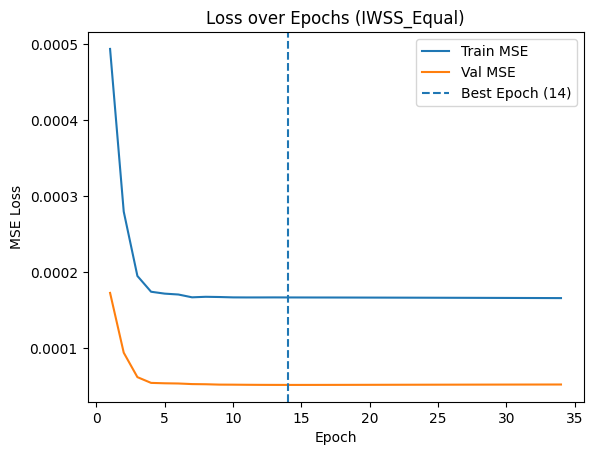

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Feature: IWSS_Equal
  MAE:  0.005647
  MSE:  0.000052
  RMSE: 0.007204
  R²:   -0.068248
  DirAcc: 0.551

=== Training with feature: IWSS_Ratio ===
Epoch 1/200
15/15 - 2s - 141ms/step - loss: 0.0039 - mae: 0.0441 - rmse: 0.0622 - val_loss: 7.7016e-04 - val_mae: 0.0221 - val_rmse: 0.0278
Epoch 2/200
15/15 - 0s - 20ms/step - loss: 6.1035e-04 - mae: 0.0180 - rmse: 0.0247 - val_loss: 6.6970e-05 - val_mae: 0.0065 - val_rmse: 0.0082
Epoch 3/200
15/15 - 0s - 18ms/step - loss: 2.4988e-04 - mae: 0.0118 - rmse: 0.0158 - val_loss: 1.1859e-04 - val_mae: 0.0091 - val_rmse: 0.0109
Epoch 4/200
15/15 - 0s - 19ms/step - loss: 2.2266e-04 - mae: 0.0111 - rmse: 0.0149 - val_loss: 5.5335e-05 - val_mae: 0.0059 - val_rmse: 0.0074
Epoch 5/200
15/15 - 0s - 16ms/step - loss: 1.8736e-04 - mae: 0.0102 - rmse: 0.0137 - val_loss: 5.6425e-05 - val_mae: 0.0059 - val_rmse: 0.0075
Epoch 6/200
15/15 - 0s - 9ms/step - loss: 1.7541e-04 - mae: 0.0100 - rmse: 0.0132 - val_loss: 5.6396e-

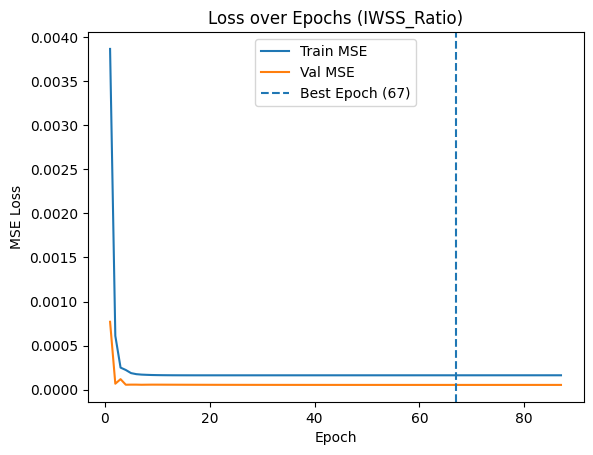

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Feature: IWSS_Ratio
  MAE:  0.005727
  MSE:  0.000053
  RMSE: 0.007293
  R²:   -0.094809
  DirAcc: 0.551

=== Training with feature: IWSS_Impurity ===
Epoch 1/200
15/15 - 1s - 99ms/step - loss: 0.0021 - mae: 0.0335 - rmse: 0.0461 - val_loss: 7.8128e-04 - val_mae: 0.0225 - val_rmse: 0.0280
Epoch 2/200
15/15 - 0s - 27ms/step - loss: 6.5421e-04 - mae: 0.0196 - rmse: 0.0256 - val_loss: 2.7128e-04 - val_mae: 0.0136 - val_rmse: 0.0165
Epoch 3/200
15/15 - 0s - 9ms/step - loss: 2.8148e-04 - mae: 0.0132 - rmse: 0.0168 - val_loss: 3.2319e-04 - val_mae: 0.0141 - val_rmse: 0.0180
Epoch 4/200
15/15 - 0s - 11ms/step - loss: 2.1553e-04 - mae: 0.0117 - rmse: 0.0147 - val_loss: 1.3276e-04 - val_mae: 0.0093 - val_rmse: 0.0115
Epoch 5/200
15/15 - 0s - 19ms/step - loss: 1.9735e-04 - mae: 0.0110 - rmse: 0.0140 - val_loss: 1.0560e-04 - val_mae: 0.0081 - val_rmse: 0.0103
Epoch 6/200
15/15 - 0s - 20ms/step - loss: 1.8063e-04 - mae: 0.0105 - rmse: 0.0134 - val_loss: 8.2337

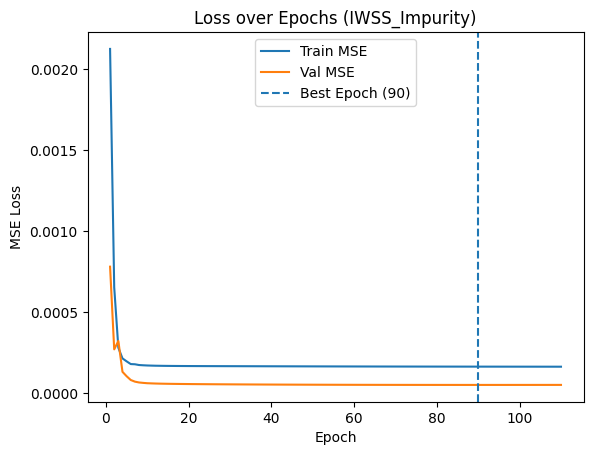

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Feature: IWSS_Impurity
  MAE:  0.005646
  MSE:  0.000052
  RMSE: 0.007213
  R²:   -0.070989
  DirAcc: 0.558

=== Training with feature: IWSS_perm ===
Epoch 1/200
15/15 - 2s - 139ms/step - loss: 9.4427e-04 - mae: 0.0234 - rmse: 0.0307 - val_loss: 3.1980e-04 - val_mae: 0.0148 - val_rmse: 0.0179
Epoch 2/200
15/15 - 0s - 18ms/step - loss: 3.2265e-04 - mae: 0.0133 - rmse: 0.0180 - val_loss: 7.3603e-05 - val_mae: 0.0068 - val_rmse: 0.0086
Epoch 3/200
15/15 - 0s - 18ms/step - loss: 2.4072e-04 - mae: 0.0116 - rmse: 0.0155 - val_loss: 7.3692e-05 - val_mae: 0.0069 - val_rmse: 0.0086
Epoch 4/200
15/15 - 0s - 18ms/step - loss: 1.9295e-04 - mae: 0.0106 - rmse: 0.0139 - val_loss: 7.1394e-05 - val_mae: 0.0063 - val_rmse: 0.0084
Epoch 5/200
15/15 - 0s - 14ms/step - loss: 1.8722e-04 - mae: 0.0105 - rmse: 0.0137 - val_loss: 6.5985e-05 - val_mae: 0.0060 - val_rmse: 0.0081
Epoch 6/200
15/15 - 0s - 10ms/step - loss: 1.8093e-04 - mae: 0.0103 - rmse: 0.0135 - val_loss: 5

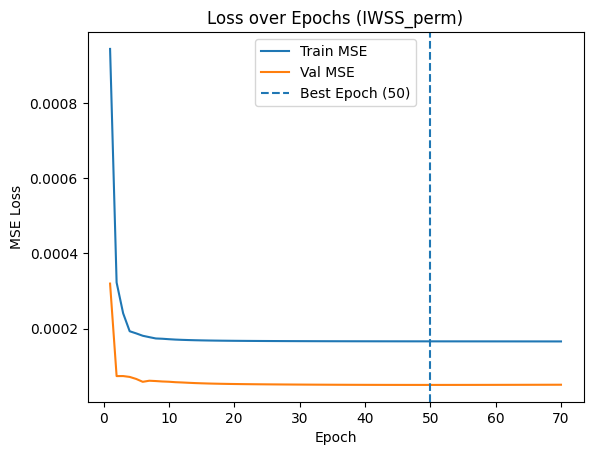

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Feature: IWSS_perm
  MAE:  0.005635
  MSE:  0.000050
  RMSE: 0.007079
  R²:   -0.031377
  DirAcc: 0.578

=== Training with feature: IWSS_SHAP ===
Epoch 1/200
15/15 - 1s - 98ms/step - loss: 3.2013e-04 - mae: 0.0138 - rmse: 0.0179 - val_loss: 1.2758e-04 - val_mae: 0.0092 - val_rmse: 0.0113
Epoch 2/200
15/15 - 0s - 11ms/step - loss: 2.2711e-04 - mae: 0.0113 - rmse: 0.0151 - val_loss: 6.3735e-05 - val_mae: 0.0061 - val_rmse: 0.0080
Epoch 3/200
15/15 - 0s - 9ms/step - loss: 1.7745e-04 - mae: 0.0101 - rmse: 0.0133 - val_loss: 7.0913e-05 - val_mae: 0.0061 - val_rmse: 0.0084
Epoch 4/200
15/15 - 0s - 11ms/step - loss: 1.8617e-04 - mae: 0.0103 - rmse: 0.0136 - val_loss: 6.4967e-05 - val_mae: 0.0062 - val_rmse: 0.0081
Epoch 5/200
15/15 - 0s - 10ms/step - loss: 1.7627e-04 - mae: 0.0102 - rmse: 0.0133 - val_loss: 6.0636e-05 - val_mae: 0.0058 - val_rmse: 0.0078
Epoch 6/200
15/15 - 0s - 22ms/step - loss: 1.7191e-04 - mae: 0.0100 - rmse: 0.0131 - val_loss: 5.5092e

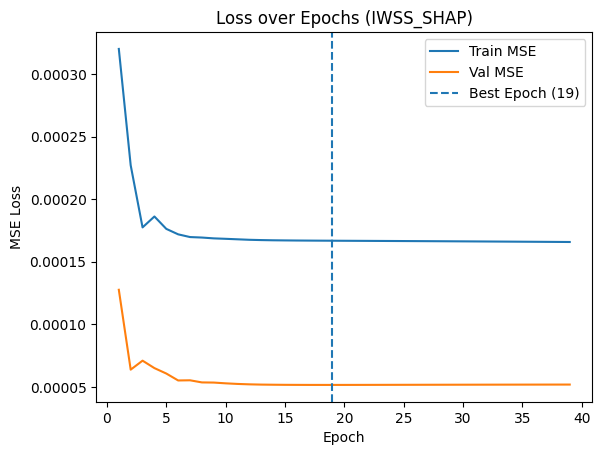

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Feature: IWSS_SHAP
  MAE:  0.005541
  MSE:  0.000052
  RMSE: 0.007178
  R²:   -0.060596
  DirAcc: 0.578

=== Training with feature: IWSS_metric ===
Epoch 1/200
15/15 - 1s - 99ms/step - loss: 0.0013 - mae: 0.0267 - rmse: 0.0355 - val_loss: 2.1734e-04 - val_mae: 0.0091 - val_rmse: 0.0147
Epoch 2/200
15/15 - 0s - 10ms/step - loss: 2.7659e-04 - mae: 0.0125 - rmse: 0.0166 - val_loss: 5.2768e-04 - val_mae: 0.0185 - val_rmse: 0.0230
Epoch 3/200
15/15 - 0s - 20ms/step - loss: 2.5416e-04 - mae: 0.0125 - rmse: 0.0159 - val_loss: 2.5302e-04 - val_mae: 0.0107 - val_rmse: 0.0159
Epoch 4/200
15/15 - 0s - 10ms/step - loss: 1.9873e-04 - mae: 0.0109 - rmse: 0.0141 - val_loss: 1.4639e-04 - val_mae: 0.0081 - val_rmse: 0.0121
Epoch 5/200
15/15 - 0s - 20ms/step - loss: 1.8489e-04 - mae: 0.0103 - rmse: 0.0136 - val_loss: 1.4460e-04 - val_mae: 0.0080 - val_rmse: 0.0120
Epoch 6/200
15/15 - 0s - 11ms/step - loss: 1.7612e-04 - mae: 0.0102 - rmse: 0.0133 - val_loss: 1.2631e-

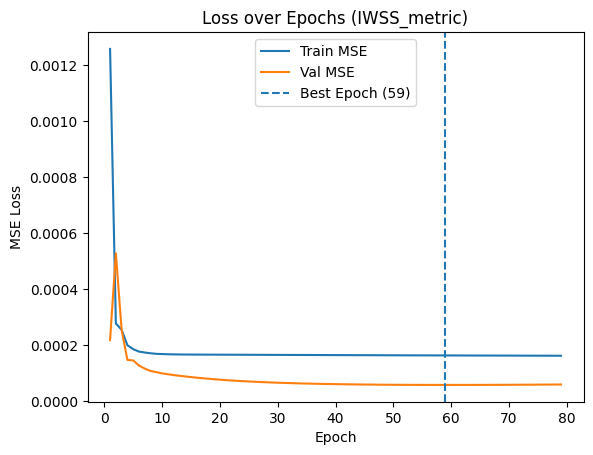

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Feature: IWSS_metric
  MAE:  0.005956
  MSE:  0.000057
  RMSE: 0.007548
  R²:   -0.172817
  DirAcc: 0.544

=== Training with feature: IWSS_PCA ===
Epoch 1/200
15/15 - 1s - 98ms/step - loss: 0.0025 - mae: 0.0354 - rmse: 0.0505 - val_loss: 2.6881e-04 - val_mae: 0.0128 - val_rmse: 0.0164
Epoch 2/200
15/15 - 0s - 32ms/step - loss: 4.6719e-04 - mae: 0.0152 - rmse: 0.0216 - val_loss: 9.2665e-05 - val_mae: 0.0077 - val_rmse: 0.0096
Epoch 3/200
15/15 - 0s - 18ms/step - loss: 2.4768e-04 - mae: 0.0118 - rmse: 0.0157 - val_loss: 7.9726e-05 - val_mae: 0.0071 - val_rmse: 0.0089
Epoch 4/200
15/15 - 0s - 15ms/step - loss: 1.9317e-04 - mae: 0.0106 - rmse: 0.0139 - val_loss: 6.5833e-05 - val_mae: 0.0063 - val_rmse: 0.0081
Epoch 5/200
15/15 - 0s - 23ms/step - loss: 1.8002e-04 - mae: 0.0102 - rmse: 0.0134 - val_loss: 5.8734e-05 - val_mae: 0.0059 - val_rmse: 0.0077
Epoch 6/200
15/15 - 0s - 17ms/step - loss: 1.7245e-04 - mae: 0.0100 - rmse: 0.0131 - val_loss: 5.8272e-0

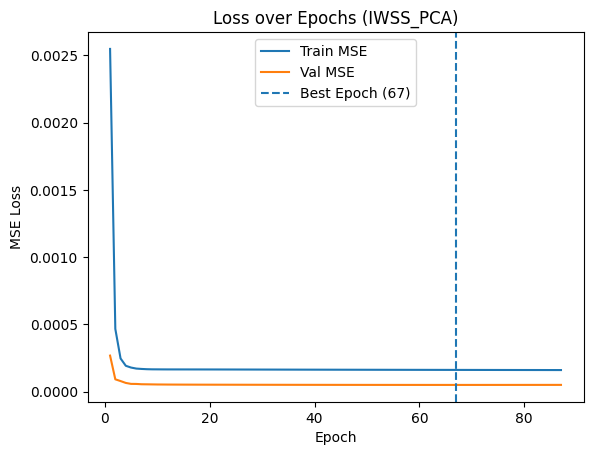

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Feature: IWSS_PCA
  MAE:  0.005474
  MSE:  0.000051
  RMSE: 0.007142
  R²:   -0.050026
  DirAcc: 0.585

=== Training with feature: Sentiment_score ===
Epoch 1/200
15/15 - 2s - 114ms/step - loss: 0.0077 - mae: 0.0672 - rmse: 0.0876 - val_loss: 0.0059 - val_mae: 0.0646 - val_rmse: 0.0766
Epoch 2/200
15/15 - 0s - 24ms/step - loss: 0.0021 - mae: 0.0353 - rmse: 0.0458 - val_loss: 7.0448e-04 - val_mae: 0.0210 - val_rmse: 0.0265
Epoch 3/200
15/15 - 0s - 12ms/step - loss: 5.5622e-04 - mae: 0.0181 - rmse: 0.0236 - val_loss: 1.4851e-04 - val_mae: 0.0099 - val_rmse: 0.0122
Epoch 4/200
15/15 - 0s - 33ms/step - loss: 2.3396e-04 - mae: 0.0115 - rmse: 0.0153 - val_loss: 1.9934e-04 - val_mae: 0.0124 - val_rmse: 0.0141
Epoch 5/200
15/15 - 0s - 33ms/step - loss: 1.9014e-04 - mae: 0.0109 - rmse: 0.0138 - val_loss: 2.3545e-04 - val_mae: 0.0135 - val_rmse: 0.0153
Epoch 6/200
15/15 - 0s - 15ms/step - loss: 1.7816e-04 - mae: 0.0104 - rmse: 0.0133 - val_loss: 1.2315e-04 -

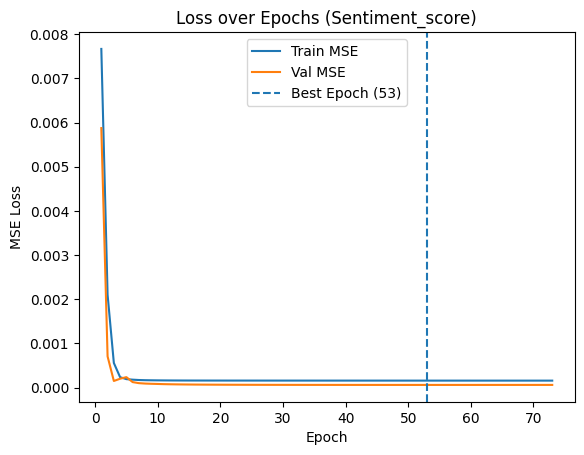

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Feature: Sentiment_score
  MAE:  0.005945
  MSE:  0.000059
  RMSE: 0.007682
  R²:   -0.214562
  DirAcc: 0.537


In [19]:
# ────────────────────────────────────────────────────────────────────────────
# 0) Installs + imports
!pip install tensorflow scikit-learn openpyxl --quiet

# ─── Reproducibility ─────────────────────────────────────────────────────────
import os, random
import numpy as np
import tensorflow as tf

SEED = 42
os.environ['PYTHONHASHSEED']      = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# ────────────────────────────────────────────────────────────────────────────
import pandas as pd
from sklearn.preprocessing    import StandardScaler
from sklearn.metrics          import (
    mean_squared_error, mean_absolute_error, r2_score, accuracy_score
)
from tensorflow.keras.models       import Sequential
from tensorflow.keras.layers       import LSTM, Dense
from tensorflow.keras.callbacks    import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

# 1) Define features and target
TARGET = 'return_t+1'
BASE_FEATS = ['return_t', 'Volume', 'VIX']
SENT_FEATS = [
    'IWSS_Equal', 'IWSS_Ratio', 'IWSS_Impurity',
    'IWSS_perm', 'IWSS_SHAP', 'IWSS_metric',
    'IWSS_PCA', 'Sentiment_score'
]

# 2) File paths
TRAIN_PATH = '/content/drive/MyDrive/Masters Thesis/Colab notebook/combined_training_data_add_spyvix.xlsx'
VAL_PATH   = '/content/drive/MyDrive/Masters Thesis/Colab notebook/combined_validation_data_add_spyvix.xlsx'

# 3) Load and clean data
def load_df(path, features):
    df = pd.read_excel(path)
    df = df.dropna(subset=features + [TARGET])
    return df.sort_values('Date').reset_index(drop=True)

# 4) Iterate over sentiment features
for feat in SENT_FEATS:
    feat_name = feat.replace('/', '_')
    features = BASE_FEATS + [feat]
    print(f"\n=== Training with feature: {feat} ===")

    # load datasets
    train_df = load_df(TRAIN_PATH, features)
    val_df   = load_df(VAL_PATH, features)

    # scale
    scaler = StandardScaler().fit(train_df[features])
    X_train = scaler.transform(train_df[features])
    X_val   = scaler.transform(val_df[features])

    # reshape for LSTM
    X_train = X_train.reshape(len(X_train), 1, len(features))
    X_val   = X_val.reshape(len(X_val),   1, len(features))

    y_train = train_df[TARGET].values
    y_val   = val_df[TARGET].values

    # build model
    def build_model(input_shape):
        m = Sequential([
            tf.keras.Input(shape=input_shape),
            LSTM(50),
            Dense(1)
        ])
        m.compile(
            optimizer='adam',
            loss='mse',
            metrics=[
                'mae',
                tf.keras.metrics.RootMeanSquaredError(name='rmse')
            ]
        )
        return m

    model = build_model((1, len(features)))

    # callbacks
    os.makedirs('models', exist_ok=True)
    ckpt_path = f'models/best_model_{feat_name}.keras'
    checkpoint = ModelCheckpoint(ckpt_path, monitor='val_loss', save_best_only=True)
    earlystop  = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

    # train
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=200, batch_size=32,
        callbacks=[checkpoint, earlystop],
        verbose=2
    )

    # plot train vs val loss
    hist = history.history
    best_ep = np.argmin(hist['val_loss']) + 1
    epochs = range(1, len(hist['loss']) + 1)
    plt.figure()
    plt.plot(epochs, hist['loss'], label='Train MSE')
    plt.plot(epochs, hist['val_loss'], label='Val MSE')
    plt.axvline(best_ep, linestyle='--', label=f'Best Epoch ({best_ep})')
    plt.title(f'Loss over Epochs ({feat})')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.show()

    # load best model and evaluate
    best_model = tf.keras.models.load_model(ckpt_path)
    y_pred = best_model.predict(X_val).flatten()

    mse      = mean_squared_error(y_val, y_pred)
    rmse     = np.sqrt(mse)
    mae      = mean_absolute_error(y_val, y_pred)
    r2_val   = r2_score(y_val, y_pred)
    dir_acc  = accuracy_score(y_val > 0, y_pred > 0)

    print(f"Feature: {feat}")
    print(f"  MAE:  {mae:.6f}")
    print(f"  MSE:  {mse:.6f}")
    print(f"  RMSE: {rmse:.6f}")
    print(f"  R²:   {r2_val:.6f}")
    print(f"  DirAcc: {dir_acc:.3f}")
